## Import libraries

In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, LabelEncoder

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [129]:
pd.set_option('display.max_columns', None)

## Load the dataset

In [130]:
# X1: entry dataset (note: X2 is the testing dataset)
# use row `Unamed: 0` as the row index
X1 = pd.read_csv("datasets/X1.csv")

print(X1.shape)
X1.head(5)

(3540, 14)


,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934..."
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722..."
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415..."
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693..."
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391..."


In [131]:
X1.loc[X1["title"] == "Clown"]

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
38,7310,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,\N,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425..."
2712,2587,Clown,https://m.media-amazon.com/images/M/MV5BMjBiOD...,Clown: Directed by Steve Lyons. With Jeff Benn...,8.6,5.0,0,2001,\N,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425..."


inputs dataset has dimension (3540, 14)

One first thing we can notice is that our dataset use a special character "\\N" for empty values. We should modify them to NaN.

In [132]:
# Y1: target dataset
Y1 = pd.read_csv("datasets/Y1.csv", header = None, names = ["revenues"])

print(Y1.shape)
Y1.head(5)

(3540, 1)


,revenues
0,7.158530e+07
1,8.964834e+04
2,3.164907e+07
3,3.898197e+07
4,9.697023e+06


target dataset has dimension (3540, 1)

In [133]:
# X2: testing entry dataset
X2 = pd.read_csv("datasets/X2.csv")

print(X2.shape)
X2.head()

(1518, 14)


,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings
0,3450,My Life Without Me,https://m.media-amazon.com/images/M/MV5BNTkxNW...,My Life Without Me: Directed by Isabel Coixet....,7.5,24256.0,0,2003,106,"Drama,Romance",2003.0,SPC,"[0.2698399, 3.1845033, 0.13669977, 0.14299123,...","[-0.62699246, 0.3949766, 0.9997058, -0.9845231..."
1,327,Fist Fight,https://m.media-amazon.com/images/M/MV5BZjg5Nj...,Fist Fight: Directed by Robert Breer. An autob...,5.9,48.0,0,1964,11,Short,2017.0,WB (NL),"[0.4279979, 0.82890534, 1.0090543, 0.17800629,...","[-0.78522605, 0.46340582, 0.9999196, -0.991904..."
2,1911,Ballerina,https://m.media-amazon.com/images/M/MV5BMzJmMj...,Ballerina: Directed by Harold D. Schuster. Wit...,6.3,6.0,0,1957,30,"Crime,Drama",2009.0,FRun,"[0.3227182, 4.6717577, 0.24727274, 0.30942556,...","[-0.51733744, 0.3527469, 0.9993828, -0.9729327..."
3,986,Hidalgo,https://m.media-amazon.com/images/M/MV5BM2MxZG...,Hidalgo: Directed by Paul Stanley. With James ...,7.9,80.0,0,1972,60,Western,2004.0,BV,"[0.011863205, 1.0377717, 0.6964849, 0.27411973...","[-0.52853703, 0.24114524, 0.998973, -0.9659761..."
4,7396,Frank & Jesse,https://m.media-amazon.com/images/M/MV5BMjA0MD...,Frank & Jesse: Directed by Robert Boris. With ...,5.8,1359.0,0,1994,105,"Biography,Western",1994.0,Trim.,"[0.18395236, 2.0983813, 0.29292667, 0.59968936...","[-0.6487137, 0.4033376, 0.999519, -0.97546834,..."


## Dataset description

inputs (X1):     
- `title`: title of the movie.    
- `ratings`: rating on IMDB.    
- `n_votes`: number of votes that are averaged for the given rating.    
- `is_adult`: is the movie destined for a mature audience (0 or 1).    
- `production_year`: the year the movie was produced.    
- `release_year`: the year the movie was released.    
- `runtime`: how long the movie lasts for.    
- `genres`: a list of maximum 3 genres that fits the movie.   
- `studio`: the movie studio that produced the movie.        
- `img.url`: the url of the poster of the movie.    
- `img.embeddings`: vector of size 2048 representing the poster.    
- `description`: synopsis of the movie.    
- `text.embeddings`: vector of size 768 representing the synopsis.

There is also an `"Unnamed: 0"` column that seems to be an **id for the movie**. We can remove it.

target (Y1):     
- `revenue`: the amount in dollars the movie made in the USA.    

## EDA and data engineering

What we're gonna do :
- Reencode some categorical variables and integers variables differently
- Remove useless / redondant features
- ...

For feature engineering and the sake of simplicity, we're gonna concatenate the inputs `X1` with the target `Y1`

In [134]:
df = pd.concat([X1, Y1], axis = 1)
df.head()

,Unnamed: 0,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,2502,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,6238,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,1800,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,2675,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,3674,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


First, let's rename `Unnamed: 0` column to `movie_id`

In [135]:
df.columns = df.columns.str.replace('Unnamed: 0','movie_id')
df.drop("movie_id", axis=1, inplace=True)
df.head()

,title,img_url,description,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,https://m.media-amazon.com/images/M/MV5BMjg0OT...,Letters to Juliet: Directed by Gary Winick. Wi...,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,https://m.media-amazon.com/images/M/MV5BZjMxOD...,Veil of Tears: Directed by William Gereghty. W...,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,https://m.media-amazon.com/images/M/MV5BOGVkYj...,International Velvet: Directed by Bryan Forbes...,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,https://m.media-amazon.com/images/M/MV5BYjY4Nz...,8 Seconds: Directed by John G. Avildsen. With ...,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,https://m.media-amazon.com/images/M/MV5BNjQyZW...,Penitentiary II: Directed by Jamaa Fanaka. Wit...,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


### Types of variables

Let's check the different types of variables

In [136]:
# types of variables
df.dtypes.value_counts()

object     8
float64    4
int64      2
dtype: int64

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            3540 non-null   object 
 1   img_url          3540 non-null   object 
 2   description      3540 non-null   object 
 3   ratings          3540 non-null   float64
 4   n_votes          3540 non-null   float64
 5   is_adult         3540 non-null   int64  
 6   production_year  3540 non-null   int64  
 7   runtime          3540 non-null   object 
 8   genres           3540 non-null   object 
 9   release_year     3540 non-null   float64
 10  studio           3540 non-null   object 
 11  img_embeddings   3540 non-null   object 
 12  text_embeddings  3540 non-null   object 
 13  revenues         3540 non-null   float64
dtypes: float64(4), int64(2), object(8)
memory usage: 387.3+ KB


Among the 8 object variables, we have the **2 vectors embeddings** as well as the `img_url` and `description` features that we could drop since we have the embeddings.
We also have the following categorical variables: `title`, `genres` and `studio`.

Finally, we have the `runtime` feature which contains `str` instead of `int`. It is because it uses "\\N" instead of NaN for missing values.

We will drop `title` feature later.

In [138]:
df.drop(columns=["img_url", "description"], inplace=True)
df.head()

,title,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,6.5,92937.0,0,2010,105,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,7.9,11.0,0,1996,\N,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,5.9,1345.0,0,1978,127,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,6.6,4851.0,0,1994,105,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,4.1,549.0,0,1982,108,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


### Duplicated observations

Let's check if we have any duplicate observations (we saw before that there could be duplicated movies with different `movie_id`)

In [139]:
df[df.duplicated()]

,title,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
190,Patti Smith: Dream of Life,7.1,978.0,0,2008,109,"Documentary,Music",2008.0,Palm,"[0.17170832, 1.569051, 0.27569252, 0.57657087,...","[-0.81552035, 0.4850951, 0.9999163, -0.9918469...",42277.098003
191,The Ox,8.2,13.0,0,1960,30,Western,1992.0,Castle,"[0.23510928, 4.0279293, 0.6071904, 0.2641873, ...","[-0.60471326, 0.30235755, 0.9994266, -0.976704...",30453.508197
260,Quiet City,6.4,1394.0,0,2007,78,Drama,2007.0,600W,"[0.036631763, 0.20270766, 0.61714303, 0.378356...","[-0.6394012, 0.3269824, 0.9992954, -0.9756729,...",22168.760251
298,Stations of the Elevated,7.4,119.0,0,1981,46,Documentary,2014.0,APD/C,"[0.09589887, 3.5422447, 0.16643104, 0.09537422...","[-0.6232235, 0.26639795, 0.9993814, -0.9771384...",35467.302070
336,The Objective,5.5,7832.0,0,2008,90,"Horror,Sci-Fi,Thriller",2009.0,IFC,"[0.13143545, 0.77969044, 0.35194525, 0.8679075...","[-0.7277447, 0.42837766, 0.99979246, -0.982731...",130.386946
...,...,...,...,...,...,...,...,...,...,...,...,...
3524,Weekend of a Champion,7.3,582.0,0,1972,80,"Action,Documentary,Sport",2013.0,SD,"[0.42331126, 4.12224, 0.4515665, 0.42120647, 0...","[-0.75798494, 0.4426181, 0.9999148, -0.9911467...",5180.429185
3528,I Can't Think Straight,6.5,7872.0,0,2008,82,"Drama,Romance",2008.0,Reg.,"[0.13882937, 1.9479853, 1.2741721, 0.32582742,...","[-0.5699436, 0.3602491, 0.9995185, -0.9824196,...",54115.998142
3530,Great World of Sound,6.7,1112.0,0,2007,106,"Comedy,Drama,Music",2007.0,Magn.,"[0.08482999, 1.7481948, 0.58276016, 0.30731, 0...","[-0.6863562, 0.3888457, 0.9996915, -0.98086303...",31259.230101
3535,Stiff Upper Lips,6.3,973.0,0,1997,94,Comedy,1999.0,Cow.,"[0.19991912, 1.3718543, 1.1531808, 0.052152418...","[-0.55224955, 0.26953417, 0.99950045, -0.98031...",128083.438175


In [140]:
df[df["title"] == "The Ox"]

,title,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
101,The Ox,8.2,13.0,0,1960,30,Western,1992.0,Castle,"[0.23510928, 4.0279293, 0.6071904, 0.2641873, ...","[-0.60471326, 0.30235755, 0.9994266, -0.976704...",30453.508197
191,The Ox,8.2,13.0,0,1960,30,Western,1992.0,Castle,"[0.23510928, 4.0279293, 0.6071904, 0.2641873, ...","[-0.60471326, 0.30235755, 0.9994266, -0.976704...",30453.508197


In [141]:
df[df.duplicated()].count()

title              432
ratings            432
n_votes            432
is_adult           432
production_year    432
runtime            432
genres             432
release_year       432
studio             432
img_embeddings     432
text_embeddings    432
revenues           432
dtype: int64

In [142]:
df.drop_duplicates(keep="first", inplace=True)

### Missing values

In [143]:
df["runtime"].describe()

count     3108
unique     185
top         \N
freq       227
Name: runtime, dtype: object

In [144]:
df["runtime"].unique()

array(['105', '\\N', '127', '108', '60', '103', '96', '89', '113', '119',
       '106', '98', '78', '115', '85', '100', '117', '92', '102', '101',
       '97', '107', '88', '26', '82', '93', '90', '94', '110', '136',
       '87', '80', '91', '95', '30', '99', '83', '71', '114', '84', '146',
       '128', '124', '86', '44', '112', '77', '104', '118', '200', '134',
       '50', '120', '69', '125', '109', '25', '111', '45', '129', '179',
       '123', '21', '79', '154', '48', '23', '116', '138', '121', '52',
       '143', '43', '168', '73', '22', '145', '167', '27', '74', '81',
       '51', '76', '46', '72', '139', '70', '12', '75', '142', '49',
       '284', '42', '3', '47', '29', '24', '162', '148', '122', '170',
       '144', '40', '5', '131', '140', '15', '169', '275', '141', '178',
       '133', '153', '6', '132', '157', '37', '163', '173', '172', '175',
       '59', '8', '135', '192', '229', '216', '130', '53', '126', '189',
       '18', '11', '41', '28', '225', '10', '55', '2', '15

In [145]:
df["genres"].unique()

array(['Adventure,Comedy,Drama', 'Action,Crime,Drama',
       'Drama,Family,Sport', 'Biography,Drama,Sport', 'Crime,Drama,Sport',
       'Action,Crime,Thriller', 'Action,Adventure,Comedy',
       'Crime,Drama,Romance', 'Crime,Drama', 'Thriller',
       'Comedy,Drama,Romance', 'Action,Adventure,Fantasy',
       'Comedy,Romance', 'Comedy,Sport', 'Documentary,Music',
       'Documentary', 'Action,Adventure,Animation',
       'Action,Adventure,Sci-Fi', 'Drama', 'Horror,Sci-Fi',
       'Drama,Family,Fantasy', 'Comedy,Drama,Family', 'Drama,Romance',
       'Action,Sci-Fi', 'Horror', 'Family,Sci-Fi', 'Comedy',
       'Animation,Comedy,Family', 'Crime,Thriller', 'Action,Drama',
       'Comedy,Drama', 'Comedy,Family,Sci-Fi', 'Comedy,Horror',
       'Drama,Musical', 'Adventure,Drama,Family', 'Drama,Mystery',
       'Crime,Mystery,Thriller', 'Documentary,Sport',
       'Adventure,Drama,Sci-Fi', 'Horror,Thriller',
       'Adventure,Drama,History', 'Comedy,Drama,War',
       'Adventure,Comedy,Crime

Let's see if there is any empty values

In [146]:
df.isna().sum()

title              0
ratings            0
n_votes            0
is_adult           0
production_year    0
runtime            0
genres             0
release_year       0
studio             0
img_embeddings     0
text_embeddings    0
revenues           0
dtype: int64

As we saw before, there is no empty values because this dataset uses the character "\\N" for empty values. Let's modify it to NaN.

We also convert type of `runtime` feature to `int` instead of `float`.

In [147]:
# replace "\\N" by "-1" (just for conversion to int)
df.replace("\\N", "-1", inplace=True)

# convert to int
df["runtime"] = df["runtime"].astype(int)

# replace -1 (for column runtime) and "-1" (for column genres) by NaN
df.replace(-1, np.nan, inplace=True)
df.replace("-1", np.nan, inplace=True)

In [148]:
df["runtime"].unique()

array([105.,  nan, 127., 108.,  60., 103.,  96.,  89., 113., 119., 106.,
        98.,  78., 115.,  85., 100., 117.,  92., 102., 101.,  97., 107.,
        88.,  26.,  82.,  93.,  90.,  94., 110., 136.,  87.,  80.,  91.,
        95.,  30.,  99.,  83.,  71., 114.,  84., 146., 128., 124.,  86.,
        44., 112.,  77., 104., 118., 200., 134.,  50., 120.,  69., 125.,
       109.,  25., 111.,  45., 129., 179., 123.,  21.,  79., 154.,  48.,
        23., 116., 138., 121.,  52., 143.,  43., 168.,  73.,  22., 145.,
       167.,  27.,  74.,  81.,  51.,  76.,  46.,  72., 139.,  70.,  12.,
        75., 142.,  49., 284.,  42.,   3.,  47.,  29.,  24., 162., 148.,
       122., 170., 144.,  40.,   5., 131., 140.,  15., 169., 275., 141.,
       178., 133., 153.,   6., 132., 157.,  37., 163., 173., 172., 175.,
        59.,   8., 135., 192., 229., 216., 130.,  53., 126., 189.,  18.,
        11.,  41.,  28., 225.,  10.,  55.,   2., 159., 174., 160.,   7.,
       420., 197.,  63., 155., 150., 152.,  20.,  1

In [149]:
df["genres"].unique()

array(['Adventure,Comedy,Drama', 'Action,Crime,Drama',
       'Drama,Family,Sport', 'Biography,Drama,Sport', 'Crime,Drama,Sport',
       'Action,Crime,Thriller', 'Action,Adventure,Comedy',
       'Crime,Drama,Romance', 'Crime,Drama', 'Thriller',
       'Comedy,Drama,Romance', 'Action,Adventure,Fantasy',
       'Comedy,Romance', 'Comedy,Sport', 'Documentary,Music',
       'Documentary', 'Action,Adventure,Animation',
       'Action,Adventure,Sci-Fi', 'Drama', 'Horror,Sci-Fi',
       'Drama,Family,Fantasy', 'Comedy,Drama,Family', 'Drama,Romance',
       'Action,Sci-Fi', 'Horror', 'Family,Sci-Fi', 'Comedy',
       'Animation,Comedy,Family', 'Crime,Thriller', 'Action,Drama',
       'Comedy,Drama', 'Comedy,Family,Sci-Fi', 'Comedy,Horror',
       'Drama,Musical', 'Adventure,Drama,Family', 'Drama,Mystery',
       'Crime,Mystery,Thriller', 'Documentary,Sport',
       'Adventure,Drama,Sci-Fi', 'Horror,Thriller',
       'Adventure,Drama,History', 'Comedy,Drama,War',
       'Adventure,Comedy,Crime

Now, we can check for any empty values

In [150]:
# number of missing values
df.isna().sum()

title                0
ratings              0
n_votes              0
is_adult             0
production_year      0
runtime            227
genres               3
release_year         0
studio               0
img_embeddings       0
text_embeddings      0
revenues             0
dtype: int64

There are 227 missing values for `runtime` feature and 3 missing values for `genres` feature

In [151]:
# percentage of missing values
((df.isna().sum() / df.shape[0]) * 100).round(decimals = 2)

title              0.0
ratings            0.0
n_votes            0.0
is_adult           0.0
production_year    0.0
runtime            7.3
genres             0.1
release_year       0.0
studio             0.0
img_embeddings     0.0
text_embeddings    0.0
revenues           0.0
dtype: float64

<AxesSubplot:>

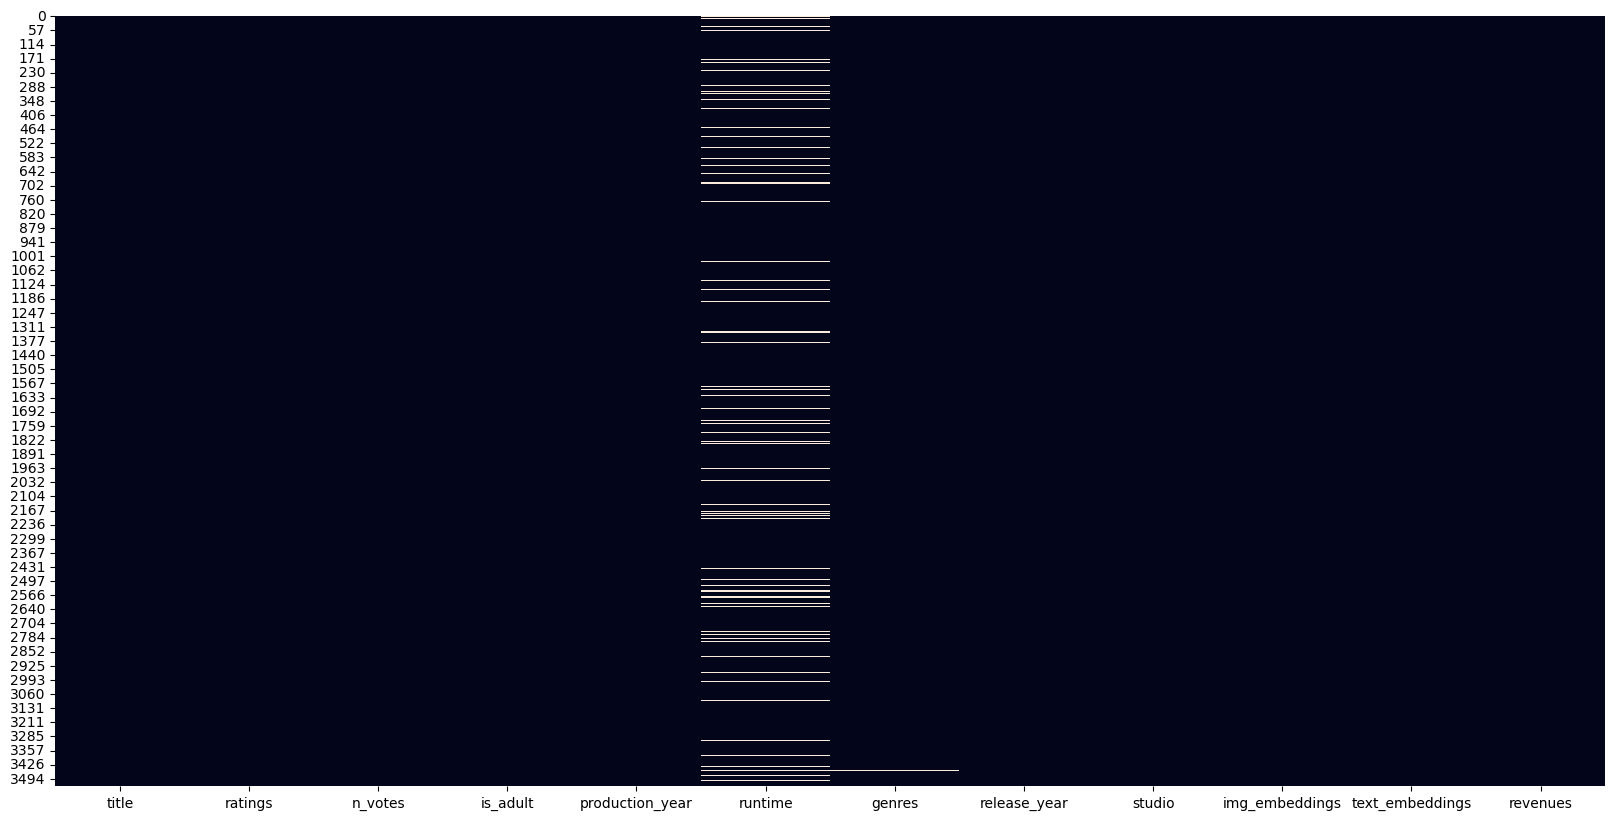

In [152]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.isna(), cbar = False)

Let's check the rows containing missing values

In [153]:
df.loc[df.isna().any(axis=1)]

,title,ratings,n_votes,is_adult,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
1,Veil of Tears,7.9,11.0,0,1996,NaN,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
9,Change of Plans,8.2,12.0,0,1992,NaN,"Crime,Drama",2010.0,IFC,"[0.20134872, 3.3128614, 1.3217659, 0.05505188,...","[-0.7538657, 0.43110898, 0.9997868, -0.9895797...",6.305640e+04
38,Clown,8.6,5.0,0,2001,NaN,"Animation,Comedy,Family",2016.0,W/Dim.,"[0.14516667, 0.06064418, 0.15632975, 0.1824489...","[-0.65403396, 0.3780646, 0.999505, -0.97987425...",6.747525e+04
41,Rugrats in Paris: The Movie,6.4,74.0,0,2000,NaN,"Action,Adventure,Comedy",2000.0,Par.,"[0.47641614, 0.82069486, 0.22295909, 0.1736825...","[-0.68661237, 0.37858504, 0.9997692, -0.978913...",1.308007e+08
57,In Bloom,8.4,16.0,0,2004,NaN,"Drama,Mystery",2014.0,BWP,"[0.30072853, 3.2013667, 0.42100322, 0.10732664...","[-0.787354, 0.46719107, 0.9998723, -0.9922189,...",6.976546e+04
...,...,...,...,...,...,...,...,...,...,...,...,...
3463,Noises Off,7.1,7.0,0,1982,NaN,Comedy,1992.0,BV,"[0.010349306, 0.56857854, 0.63633597, 0.025205...","[-0.57973355, 0.3638104, 0.9994841, -0.9829557...",4.784573e+06
3478,The Star Maker,8.5,25.0,0,1957,NaN,Comedy,1996.0,Mira.,"[0.1930125, 0.86812514, 1.0944237, 0.11855329,...","[-0.69110036, 0.39354154, 0.9996875, -0.983344...",6.973921e+05
3496,Dog Days of Summer,6.2,6.0,0,1993,NaN,"Animation,Comedy,Family",2008.0,MTop,"[0.21031177, 0.622036, 0.10827673, 0.14782186,...","[-0.672096, 0.35698575, 0.9996098, -0.98000515...",7.360684e+03
3504,Area 51,5.7,6.0,0,2004,NaN,Documentary,2015.0,PARAIN,"[0.68146044, 1.8886466, 2.4086003, 0.9816384, ...","[-0.6459968, 0.31116134, 0.99957985, -0.981476...",9.386019e+03


**Rule of thumb**: _if values are missing at random and percentage of observations with these missing values are less than $5\%$. We can drop them without risking of creating bias in our dataset._

We have $0.3\%$ of entries with missing values for `genres` features. These are random missing values (no reason for these to be missing, probably forgotten) so we can definitelty drop these entries without risk of creating bias in our dataset.
However, for the `runtime` feature, we have ~ $7\%$ of missing values. That's a little bit much for removing all these entries even though they also seem to be random missing values.

We could try to impute by mean or something else.

0    90.0
Name: runtime, dtype: float64


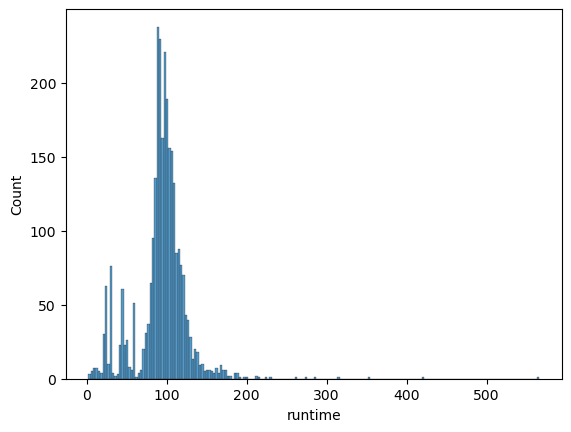

In [154]:
sns.histplot(df["runtime"])

print(df["runtime"].mode())

If data is missing randomly but the rows with these missing values are more than $5\%$ of the dataset, we can use **mean** (in case feature is normally distributed) or **median** (otherwise) imputation. We can also consider **mode** imputation.

However, keep in mind it affects data distribution (in particular the variance is reduced).

In [155]:
# Drop rows with NaN in genres column
df.dropna(subset=["genres"], axis=0, inplace=True)

print("runtime mean: {}".format(df["runtime"].mean()))
print("runtime median: {}".format(df["runtime"].median()))
print("runtime mode: {}".format(df["runtime"].mode()))

# Impute rows with NaN in runtime column. Replacing with mean.
df["runtime"].fillna(df["runtime"].mean(), inplace=True)

runtime mean: 93.36076388888888
runtime median: 95.0
runtime mode: 0    90.0
Name: runtime, dtype: float64


In [156]:
df.isna().sum()

title              0
ratings            0
n_votes            0
is_adult           0
production_year    0
runtime            0
genres             0
release_year       0
studio             0
img_embeddings     0
text_embeddings    0
revenues           0
dtype: int64

### Analysis of columns

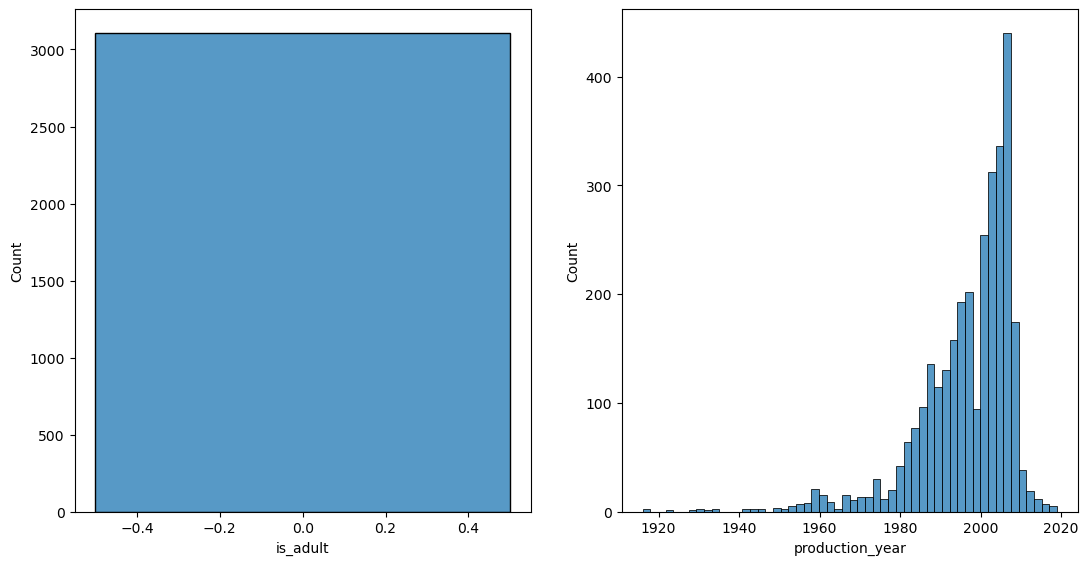

In [157]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("int"):
    plt.subplot(4,3,i)
    sns.histplot(df[col])
    i += 1

There seems to be only _non-adult_ movies (to confirm later).

Movies were mainly produced between **1990** and **2010**. We have a left skewed distribution.

In [158]:
df["is_adult"].value_counts()

0    3105
Name: is_adult, dtype: int64

Indeed, we **do not have any movies** for a _mature audience_. 
Therefore, we could drop this column.

In [159]:
df.drop(["is_adult"], axis=1, inplace=True)
df.head()

,title,ratings,n_votes,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,6.5,92937.0,2010,105.000000,"Adventure,Comedy,Drama",2010.0,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,7.9,11.0,1996,93.360764,"Action,Crime,Drama",2014.0,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,5.9,1345.0,1978,127.000000,"Drama,Family,Sport",1978.0,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,6.6,4851.0,1994,105.000000,"Biography,Drama,Sport",1994.0,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,4.1,549.0,1982,108.000000,"Crime,Drama,Sport",1982.0,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


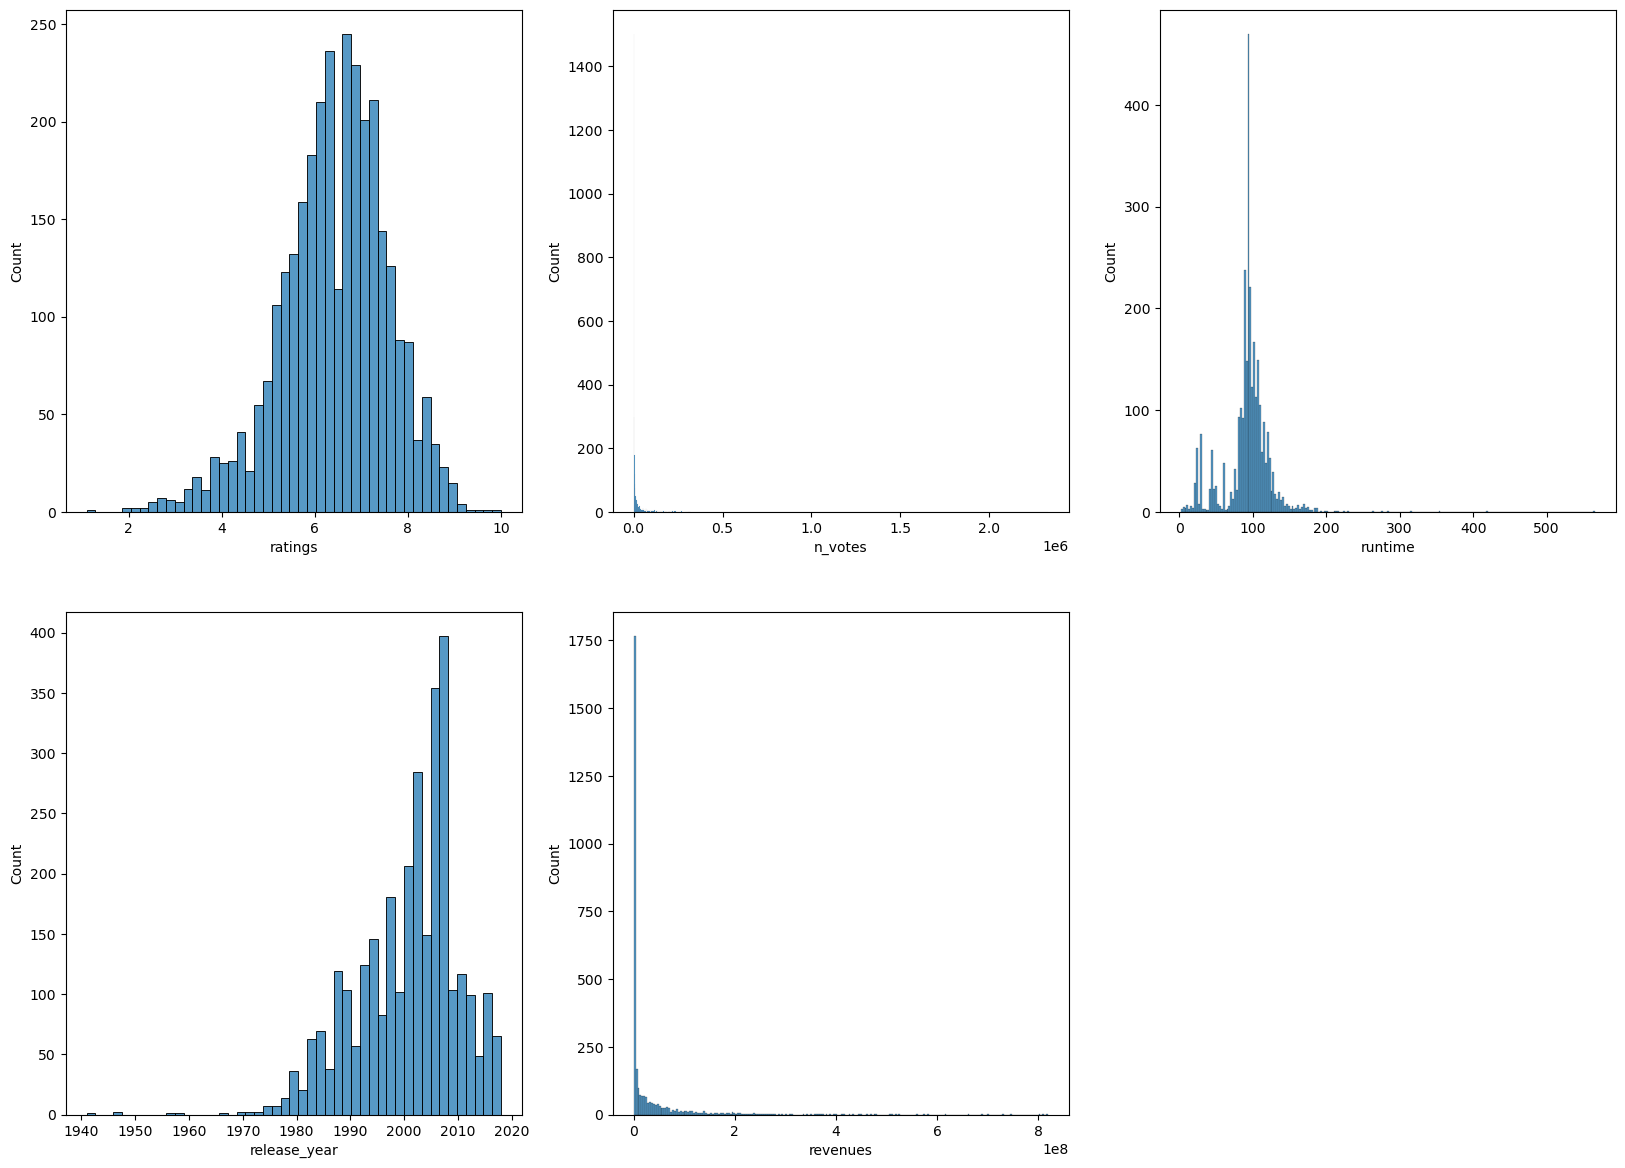

In [160]:
plt.subplots(figsize=(20,30))

i = 1

for col in df.select_dtypes("float"):
    plt.subplot(4,3,i)
    sns.histplot(df[col])
    i += 1

Ratings are more or less normally distributed with a mean around **6.5**.

The number of votes are pretty homogeneous amoung the movies.

Most movies were released between **2005** and **2010**. We have a left skewed distribution.

It doesn't seem to make sense to have `n_votes` and `release_year` as "float". Let's convert them into "int".

In [161]:
df["release_year"] = df["release_year"].astype(int)
df["n_votes"] = df["n_votes"].astype(int)

df.head()

,title,ratings,n_votes,production_year,runtime,genres,release_year,studio,img_embeddings,text_embeddings,revenues
0,Letters to Juliet,6.5,92937,2010,105.000000,"Adventure,Comedy,Drama",2010,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07
1,Veil of Tears,7.9,11,1996,93.360764,"Action,Crime,Drama",2014,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04
2,International Velvet,5.9,1345,1978,127.000000,"Drama,Family,Sport",1978,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07
3,8 Seconds,6.6,4851,1994,105.000000,"Biography,Drama,Sport",1994,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07
4,Penitentiary II,4.1,549,1982,108.000000,"Crime,Drama,Sport",1982,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06


### Skewness and outliers analysis

<AxesSubplot:ylabel='n_votes'>

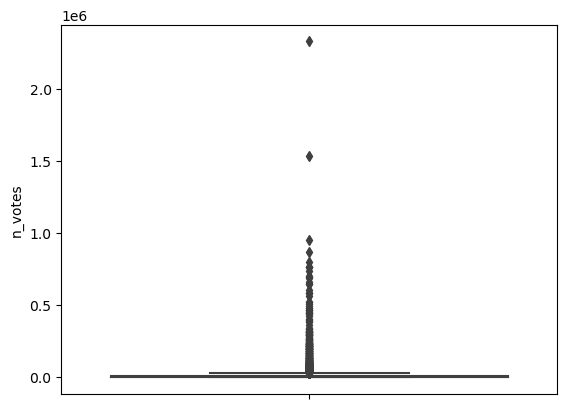

In [162]:
sns.boxplot(y = df["n_votes"])

We notice a big difference of scale for the `n_votes` feature. It also contains outliers. We do not remove outliers in testing set.

<AxesSubplot:ylabel='revenues'>

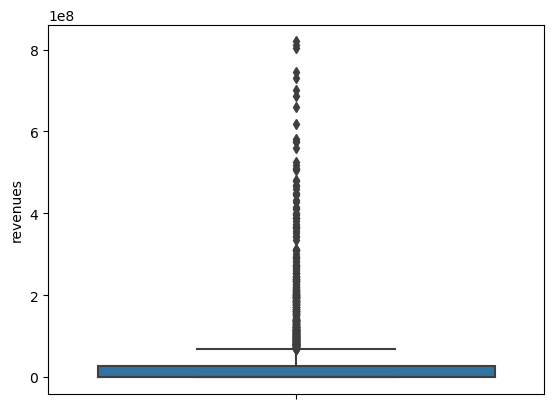

In [163]:
sns.boxplot(y = df["revenues"])

In [164]:
# TODO: remove outliers via IQR (because data has not normal shape)
def find_boundaries(df, variable):
    iqr = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_bound = df[variable].quantile(0.25) - (iqr * 1.5)
    upper_bound = df[variable].quantile(0.75) + (iqr * 1.5)

    return lower_bound, upper_bound

lower_bound_votes, upper_bound_votes = find_boundaries(X1, "n_votes")

print(lower_bound_votes)
print(upper_bound_votes)   

votes_outliers = np.where(X1["n_votes"] > upper_bound_votes, True, np.where(X1["n_votes"] < upper_bound_votes, True, False))
print(votes_outliers.sum())

X1_without_outliers = X1.loc[(~votes_outliers), ]

print(X1.shape)
print(X1_without_outliers.shape)

-13742.375
23324.625
3540
(3540, 14)
(0, 14)


Then, we standardize the data. To do that, we apply a scaler on the training set and then apply it on both training and testing sets.

In [165]:
df.describe()

,ratings,n_votes,production_year,runtime,release_year,revenues
count,3105.000000,3.105000e+03,3105.000000,3105.000000,3105.000000,3.105000e+03
mean,6.427665,2.631698e+04,1996.604509,93.360764,2000.809662,3.201075e+07
std,1.154696,9.131408e+04,11.784146,31.294917,9.377543,7.738162e+07
min,1.100000,5.000000e+00,1916.000000,2.000000,1941.000000,1.303869e+02
25%,5.800000,1.980000e+02,1991.000000,87.000000,1995.000000,7.057472e+04
50%,6.500000,1.827000e+03,2000.000000,94.000000,2003.000000,1.408586e+06
75%,7.200000,1.208900e+04,2005.000000,106.000000,2007.000000,2.785229e+07
max,10.000000,2.332286e+06,2019.000000,566.000000,2018.000000,8.199476e+08


Let's analyze the range of the different numericals features

In [166]:
df.select_dtypes(include=["int64", "float64"]).max() - df.select_dtypes(include=["int64", "float64"]).min()

ratings            8.900000e+00
n_votes            2.332281e+06
production_year    1.030000e+02
runtime            5.640000e+02
release_year       7.700000e+01
revenues           8.199474e+08
dtype: float64

### One Hot Encoding

We should then One-Hot encode the genres

In [167]:
# separate all genres into one big list of list of genres
genres_list = df["genres"].str.split(",").tolist()

unique_genres = []

# retrieve each genre
for sublist in genres_list:
    for genre in sublist:
        if genre not in unique_genres:
            unique_genres.append(genre)

# sort
unique_genres = sorted(unique_genres)
print(unique_genres)

# one hot encode movies genres
df = df.reindex(df.columns.tolist() + unique_genres, axis = 1, fill_value = 0)

for index, row in df.iterrows():
    for genre in row["genres"].split(","):
        df.loc[index, genre] = 1

['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western']


In [168]:
# drop old genres column
df.drop("genres", axis=1, inplace=True)

df.head()

,title,ratings,n_votes,production_year,runtime,release_year,studio,img_embeddings,text_embeddings,revenues,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Letters to Juliet,6.5,92937,2010,105.000000,2010,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Veil of Tears,7.9,11,1996,93.360764,2014,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,International Velvet,5.9,1345,1978,127.000000,1978,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,8 Seconds,6.6,4851,1994,105.000000,1994,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Penitentiary II,4.1,549,1982,108.000000,1982,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Embeddings: Feature extraction

converting `img_embeddings` and `text_embeddings` from **string** to **numpy array**

In [169]:
# # some tests
# #import ast

# fv = '[0.25030804, 2.4058464, 1.0431569, 0.030648155, 0.34949675, 0.32049546, 0.9010769, 0.67499596, 0.3105492, 0.53335327, 1.1203631, 1.1870352, 0.16469067, 0.08631029, 0.2536717, 0.8805131, 0.99093795, 0.5192096, 0.22073326, 1.1222858, 0.16405053, 0.43223396, 0.13318907, 0.15435342, 0.6851507, 0.29961434, 0.1571368, 0.36041096, 0.35249132, 0.41207317, 0.10110004, 0.8365802, 0.5149405, 0.956604, 0.9495678, 2.4414942, 0.3832077, 1.360116, 0.5607003, 0.21099378, 0.3635454, 0.9016296, 0.21133274, 0.80351084, 0.07196415, 0.7504479, 0.7727491, 0.6297995, 0.29605088, 0.6241131, 0.31069583, 0.47231564, 0.16313902, 0.20088163, 0.5571188, 0.38998926, 0.6070499, 0.28628415, 0.2539219, 0.7498281, 0.43571132, 0.5879961, 0.8000516, 0.35587543, 0.09601559, 0.13888705, 0.5510557, 0.22644973, 0.43565476, 0.5604339, 1.297827, 1.6763825, 0.26593068, 0.94142264, 1.0117874, 1.1187711, 0.62566483, 0.2033474, 0.4790194, 0.2834636, 0.18365589, 0.8987742, 0.6292137, 0.13599868, 0.6869864, 1.1488372, 0.98580325, 0.33732706, 1.3206652, 0.4510933, 0.28988063, 0.19096221, 0.08802719, 0.14405671, 0.81400466, 0.6161603, 0.3183229, 0.17775397, 0.7540709, 0.31884822, 0.5587284, 0.6364966, 0.5786795, 0.123752765, 0.2925977, 0.4696877, 1.1519421, 0.61845815, 0.16416119, 0.5900066, 0.29206434, 0.83303666, 0.5063075, 0.19821224, 0.27243552, 0.30711204, 0.37947264, 0.33710697, 0.42839894, 1.1144278, 0.36248904, 0.5618366, 0.7529292, 0.19503462, 0.08051537, 0.2711099, 0.53147835, 0.50948185, 0.72030675, 0.36676234, 0.26366168, 0.72022355, 0.65135866, 0.7772263, 0.7106988, 0.80478275, 0.5667672, 0.581735, 1.4859661, 1.0217708, 0.60501784, 0.29635093, 0.04777985, 0.0580555, 0.9841352, 0.02218431, 0.37477398, 0.118988864, 0.1045922, 0.97314125, 0.5293767, 0.6148842, 0.99536574, 0.3106915, 0.3382719, 0.6779338, 0.4008454, 1.4224113, 0.21727964, 0.80454624, 0.4521122, 0.65333027, 0.3192505, 1.0585511, 0.36981302, 0.7075969, 0.4972893, 0.3955303, 0.8732011, 0.79539937, 0.5387731, 0.7555784, 0.58415884, 0.7133316, 1.9607952, 0.19404714, 0.5236713, 0.16782571, 0.31456107, 1.8233552, 0.3235115, 1.6313598, 0.174841, 1.6211541, 0.6552884, 1.3179861, 0.96339446, 0.17816857, 0.38407034, 0.11434893, 0.04340038, 0.13055539, 0.7282053, 0.6503499, 0.79448014, 0.38980266, 0.14346373, 0.6503325, 0.37672266, 0.013478814, 0.68465656, 0.2160412, 0.17561743, 0.632174, 0.24992894, 0.30823028, 0.3360596, 0.49720246, 0.9016037, 0.9401362, 0.4507533, 0.71566975, 0.40894374, 0.3905219, 0.8095464, 0.15091981, 1.5565699, 0.20029166, 0.40923506, 0.13582149, 0.5563764, 0.2532752, 0.33110872, 0.50609815, 0.6409707, 0.8184397, 0.6745204, 0.9584001, 1.1786208, 1.2402498, 0.3465486, 0.21476422, 0.1460548, 0.29341164, 0.0074888756, 1.3077303, 0.36490014, 0.65103185, 1.0814037, 0.66878307, 1.2192987, 0.32649627, 0.35315007, 1.5046281, 0.36437315, 0.40984604, 1.4268281, 0.07104521, 0.32629827, 0.49439514, 0.5230511, 1.1388099, 0.9052732, 0.7678389, 0.7523143, 0.05222644, 0.79931164, 0.39785323, 0.1301564, 0.0963407, 0.22866334, 0.2898883, 0.22431125, 0.52764285, 0.7496524, 0.14661124, 0.34608924, 0.67633927, 0.2558242, 0.7052168, 0.38569543, 0.10814382, 0.24396212, 0.21739535, 0.75940067, 0.05861001, 0.27887055, 0.4059211, 0.6406037, 0.04229594, 1.2036061, 0.0001704048, 0.44607818, 0.3076998, 1.8923558, 0.13493057, 1.27033, 0.5113912, 0.6645333, 0.26291248, 0.4251616, 0.46974474, 0.81584555, 1.0836968, 0.40288278, 0.048438232, 1.1543372, 0.49324307, 0.7790551, 0.03504371, 1.2020212, 1.3406855, 0.3205428, 0.7997628, 0.360869, 1.2281494, 0.4921014, 0.643174, 1.1563631, 0.37391344, 0.08788868, 0.42171746, 0.17398347, 0.9803269, 0.21352024, 1.2042394, 0.14207394, 1.0541555, 0.14357542, 0.13436319, 0.653163, 0.8821295, 0.537969, 0.40038973, 0.21653286, 0.12753889, 0.18921334, 0.35908654, 0.3648608, 0.20868756, 0.35053116, 0.2703145, 0.18326084, 0.6119104, 0.9181951, 0.881173, 0.9834819, 0.07432893, 0.37074777, 2.0549595, 0.5161843, 1.0513735, 0.43206027, 1.0906221, 0.27588704, 1.0785121, 0.7931386, 0.66219306, 1.841875, 0.15010744, 0.82433647, 0.20971002, 0.68839335, 1.1980159, 0.69889396, 0.8423599, 0.49809042, 0.31714293, 0.5511521, 0.07991337, 0.17475432, 0.25061172, 0.5437919, 0.13326555, 1.0135624, 0.5950583, 0.7489583, 1.0107996, 0.9440712, 0.44399798, 0.5220292, 1.9968383, 0.870572, 0.8481719, 0.64561796, 0.10215983, 0.2437537, 0.8493073, 0.14569372, 0.8800276, 0.06724539, 0.9631338, 0.73272717, 0.2300618, 0.32537866, 0.22076066, 0.68405443, 0.7271958, 0.4918333, 0.37118036, 0.8110152, 0.13678543, 0.27749774, 0.79484737, 1.4411341, 0.52540946, 0.6336789, 0.044917636, 0.21799743, 0.2555888, 0.17549446, 0.170978, 0.2768373, 0.12958239, 0.12942526, 0.15889607, 0.47523004, 0.69294876, 0.26725984, 1.2692502, 0.21668902, 0.94401705, 0.20680189, 0.17620966, 0.7221054, 0.15739553, 0.12480383, 0.47154886, 0.1755442, 1.0154352, 0.4672548, 0.4611733, 0.18285973, 0.23024699, 0.123174295, 0.2341165, 0.70021605, 0.11815044, 0.8694062, 0.31799752, 0.16790082, 0.95745504, 0.17672691, 0.27406353, 1.4548346, 0.331358, 0.05034857, 0.15657069, 0.45870483, 0.07948745, 0.08258012, 0.58511317, 0.09342516, 0.2612393, 0.40571195, 0.068124495, 1.2290903, 0.14491235, 0.64656293, 0.8061791, 1.2098912, 0.27695736, 0.022614669, 0.45702818, 0.3650799, 0.7983299, 0.12225879, 1.8319328, 0.43000934, 0.22311898, 0.08191774, 0.7944028, 0.26791623, 0.73540705, 1.8097119, 0.33347765, 0.7295549, 2.2048943, 0.71663535, 0.64639574, 0.7736921, 0.09921727, 0.37119398, 0.5273572, 0.022357069, 0.10605119, 0.61041063, 1.0140077, 2.0946772, 0.33401605, 0.80440223, 0.4879991, 0.40319568, 0.56553406, 0.6505985, 0.7919503, 0.21408412, 0.043300472, 0.6287988, 0.17334165, 0.33457184, 0.25179556, 0.100660525, 0.67658293, 0.3062903, 0.7160742, 0.34100333, 0.1461126, 0.31062073, 0.4376086, 0.56204027, 1.1436846, 0.14869863, 0.7937177, 0.28302306, 0.17167962, 0.15781151, 0.5203733, 0.6925702, 0.31311834, 0.5682014, 0.42978853, 0.58384496, 0.23366484, 0.55079496, 0.3094724, 0.36317724, 0.47860327, 0.97042656, 0.32355666, 0.2225228, 0.3838356, 0.5530373, 0.119849235, 0.1835413, 0.9208266, 0.40341955, 0.2719048, 0.47736722, 0.18264213, 0.1784132, 1.0957989, 1.4820542, 0.7124748, 0.38190565, 0.34974545, 0.17382018, 0.34471232, 1.6687638, 0.8275084, 0.58711886, 1.635049, 0.055099744, 0.053317025, 0.3578614, 0.6801141, 0.12537771, 1.4095412, 0.5687685, 0.6556246, 0.44688493, 0.8710935, 0.6127056, 0.5419833, 0.27641755, 0.46263325, 0.2152478, 0.54190177, 0.13220644, 0.25084215, 0.42904758, 1.4509565, 0.7452599, 1.3449504, 0.7150657, 0.15225004, 0.68198097, 0.7115492, 0.062808976, 1.4577702, 1.1125112, 0.9986411, 0.27615595, 0.21841271, 0.52607226, 1.9552478, 0.55862623, 0.09615844, 0.015544571, 1.0038383, 0.060185406, 0.5896757, 0.66460884, 0.14025638, 0.22790962, 0.2618285, 0.22907768, 0.8326648, 0.9907251, 0.74442345, 0.16136417, 0.35110644, 0.8998789, 0.9950287, 1.3590708, 0.9449283, 1.0015755, 0.25671816, 1.3286372, 1.6311569, 0.28421745, 0.22281829, 0.36999854, 0.16725312, 1.2169845, 0.8390713, 0.17471313, 0.7105591, 0.26912567, 0.37676024, 0.2081298, 0.17984882, 0.16956788, 1.6300781, 0.30397657, 0.9458973, 0.67105365, 0.16348961, 0.70702845, 0.24676828, 1.4820615, 0.13212584, 1.2175161, 0.42071906, 4.0033927, 0.33633184, 0.39174718, 0.30761987, 0.08192619, 0.12137812, 0.7380272, 0.24753192, 0.5963602, 0.39482412, 1.5315676, 0.42122173, 0.4674936, 1.4463152, 0.5594742, 1.7722597, 1.9967704, 0.59758246, 0.107849784, 0.48410177, 0.40279925, 0.9941864, 0.4165693, 0.7897021, 0.16578397, 1.041232, 0.25925165, 0.24593808, 0.396791, 1.3828799, 1.5648552, 0.2398757, 1.1622311, 0.60321176, 0.07598192, 0.10254638, 0.17724742, 0.4875105, 0.15353891, 0.21464601, 0.9744452, 0.03563445, 0.67139316, 0.5320366, 0.23927218, 0.52041703, 0.21643397, 1.3983831, 0.54408085, 0.4030213, 0.40364265, 0.88080424, 1.0252541, 0.26783445, 0.26973245, 0.09320547, 0.4241846, 0.32919386, 1.150492, 0.8167905, 0.586686, 0.44818115, 0.12069223, 0.37676308, 0.27696234, 0.35552385, 0.72490627, 0.29933068, 1.4218102, 0.045925036, 0.3258933, 0.92012715, 0.97546834, 0.40834495, 0.5199563, 0.82466185, 0.07873449, 0.1898224, 0.13660112, 0.40819383, 0.34215817, 1.0090005, 0.29623213, 0.07036145, 0.048944775, 0.7072609, 0.5484529, 1.3166958, 0.9410679, 0.29601276, 0.31850222, 0.045467634, 0.33995622, 0.041682202, 0.6502576, 0.33114588, 0.3818426, 1.3118634, 0.25090334, 0.15516773, 0.713122, 0.80729216, 0.65615034, 0.69695693, 0.10477702, 0.6766564, 1.0744289, 0.92527795, 1.3894856, 0.5212803, 1.0682391, 0.19858475, 0.649648, 0.5279763, 0.13652927, 0.95764875, 0.03125023, 0.26984563, 0.44423866, 0.5316093, 1.304298, 1.0725819, 0.9319319, 0.47057116, 0.20390347, 0.9245576, 1.3402066, 0.8444632, 2.02272, 0.34440324, 0.021232994, 1.2992648, 0.3937798, 0.20641202, 0.37747896, 0.5877824, 0.59766066, 0.67842835, 0.03182481, 0.9814273, 0.4916392, 0.2249838, 0.0588807, 0.4980365, 0.5439434, 0.11547546, 1.2843866, 0.27332255, 0.83732915, 0.6213801, 0.68649244, 0.21933329, 0.27009225, 0.69353515, 0.4759112, 0.15493032, 1.1557325, 1.0042186, 1.2971451, 0.23373105, 0.39605206, 0.36106506, 0.23363452, 0.79699886, 0.18960851, 0.5073987, 0.77483094, 0.030643703, 0.3772182, 0.4159419, 0.8629007, 0.87216175, 0.70061845, 0.14743318, 0.21073602, 1.1152625, 0.560361, 1.4986196, 0.08364754, 0.53428674, 0.31287003, 0.8469125, 0.7649872, 0.6139656, 0.33962506, 0.3050584, 0.28252423, 0.1659698, 0.61581284, 0.1712382, 0.6606146, 0.21951516, 0.07012032, 0.93940735, 0.06497968, 0.75595444, 0.6387049, 0.9842058, 0.8654542, 1.3236761, 0.23727775, 0.57282054, 0.16971241, 0.33449242, 1.0380406, 0.56317335, 0.9107895, 0.12078334, 0.056811865, 0.3862312, 0.06529412, 0.28737918, 0.8105037, 0.23517083, 0.4177085, 0.41814515, 0.14190473, 0.38645115, 0.25959462, 0.16898957, 0.4410162, 0.31463045, 0.61761355, 0.359743, 1.2572945, 0.6240976, 1.135463, 1.1230577, 0.1956566, 0.7842662, 1.6176733, 1.7931709, 0.11943297, 0.28768176, 0.34262115, 0.6881706, 0.20374677, 0.52413714, 0.32582828, 0.6140548, 0.61737704, 1.8640544, 0.038974393, 1.2969912, 1.097364, 0.2386584, 0.902042, 1.0803843, 0.00058916153, 0.34257254, 0.04905834, 1.0168372, 2.3793826, 1.4103119, 1.8945997, 1.087137, 0.4842858, 1.2054411, 0.082479045, 0.72814226, 0.47388604, 0.31906998, 0.40005, 0.654263, 0.54776937, 0.7448744, 0.073941596, 0.48999473, 0.6382231, 0.9508631, 0.33351758, 1.3988909, 0.3610008, 0.6054233, 0.16047205, 0.23254447, 0.5550868, 1.0261011, 1.8111018, 0.20408763, 0.3771247, 0.047781818, 0.37548944, 0.4508103, 0.79440534, 0.4913295, 0.028227512, 0.2315951, 0.62305945, 2.1421545, 0.43048152, 0.74457127, 0.62589806, 0.57182753, 0.4577628, 0.31916532, 0.27399608, 1.2916355, 0.50454986, 0.7953013, 0.20886028, 0.8487048, 0.057692327, 0.6023834, 0.4650906, 0.5985769, 0.11508114, 0.6759697, 0.15626249, 0.5195129, 0.80449706, 0.33005193, 1.2821927, 0.3638883, 0.33056664, 0.56923485, 0.0019754325, 0.52558625, 0.50648004, 0.15712929, 1.0387874, 1.9954921, 0.23549512, 0.50960904, 0.27236497, 2.3668177, 0.28423014, 0.23178072, 0.6917075, 0.381325, 1.4167191, 1.6418815, 0.92548555, 0.13640688, 1.4428431, 1.4649419, 0.09050863, 0.19187336, 1.6276165, 1.806823, 0.73565966, 0.364977, 0.3103996, 0.38862383, 0.25849295, 1.2377259, 0.62118405, 0.07928719, 1.3048624, 0.25978106, 0.122669734, 0.25335455, 0.07375452, 0.47716695, 0.38913804, 0.60699755, 0.46889418, 0.28239605, 0.097375326, 0.22990732, 0.1558708, 0.23824221, 0.94341433, 0.41349605, 1.3359833, 0.6977891, 0.7308564, 2.200664, 1.3756648, 0.20629874, 1.1143571, 0.08969769, 0.41149694, 0.48498508, 0.23930652, 0.27432752, 1.2020383, 0.3537125, 0.7854259, 0.41470253, 0.8659706, 0.96877736, 0.5534315, 0.32915586, 0.67638963, 2.058437, 0.97249633, 0.15000376, 0.7290967, 0.3210861, 0.7806546, 0.25358614, 0.5156649, 0.074234016, 0.21341546, 2.074595, 1.2005447, 0.4587611, 0.574439, 0.86004245, 0.80064094, 0.102451466, 0.53094894, 0.6048262, 0.40237838, 0.20601009, 0.7925826, 0.8618101, 0.5020299, 0.3444532, 0.17728615, 1.301846, 1.2399248, 2.0571458, 1.0702608, 0.58614385, 0.1842829, 0.3410707, 1.0004386, 0.3350346, 0.7984183, 0.34692743, 0.5914575, 1.1157058, 0.7731678, 1.1932805, 0.7003606, 1.0774462, 0.25226173, 0.2290273, 0.38833314, 0.028031396, 1.022422, 0.25361362, 1.4461555, 1.0869378, 0.15873529, 0.39298135, 0.2948793, 0.1316423, 0.14610577, 0.51383454, 0.25808868, 0.3188856, 0.1664721, 0.26505896, 0.7063161, 0.304047, 0.89056754, 0.37134105, 1.0631506, 0.32667643, 0.66099316, 0.19835767, 0.61553097, 0.55503154, 1.1819875, 0.5382854, 1.0439165, 0.42969334, 0.23310137, 0.4636376, 0.6108666, 0.72155637, 0.44779682, 0.81175864, 1.0201117, 0.2624006, 1.246873, 2.7987263, 0.34592164, 0.76121444, 0.5965651, 0.58987576, 0.40072677, 0.5158991, 1.7961341, 0.24626657, 0.110195264, 0.6755196, 0.6103379, 0.31415468, 0.06837223, 0.13888203, 0.9764467, 0.37463766, 0.24890098, 1.4056556, 0.6961254, 0.67990774, 0.5441076, 1.3214442, 1.649169, 0.01572272, 0.17560104, 0.07561996, 0.50147504, 0.51629704, 0.7162726, 0.7043105, 1.3010734, 0.9394674, 0.63584584, 0.6836154, 0.14362246, 0.5014272, 0.31281942, 0.3981927, 0.771667, 0.27040836, 0.6815076, 0.47105244, 0.17871332, 1.08071, 0.7312765, 1.2194017, 1.2130778, 0.037817627, 0.15791836, 0.17593995, 0.035662796, 0.07538241, 0.15779558, 0.7418321, 1.2527863, 0.3982507, 0.24464509, 0.66191363, 0.07716726, 1.0937057, 0.65109235, 0.16187352, 0.29063874, 0.6442326, 0.6838235, 0.7136946, 0.024438202, 1.2145407, 0.45821142, 0.10175489, 0.19197635, 0.6634268, 0.75747234, 0.08794922, 0.5853321, 0.30626124, 1.1734899, 0.52242786, 0.20253152, 0.51598614, 1.5532446, 0.4772585, 0.267215, 0.35823044, 0.31502214, 0.6001401, 0.07032968, 0.21484935, 0.4849208, 0.3337751, 1.06748, 0.5677559, 1.0559542, 0.33990824, 1.0513393, 1.2527852, 1.2406948, 1.3844782, 6.273328e-05, 0.13538308, 1.0187736, 0.8730055, 0.599036, 1.937007, 0.5406084, 2.687023, 0.31763953, 0.7392232, 0.8719844, 1.9610468, 0.37475753, 0.39965424, 0.10504549, 0.10370811, 0.5026334, 0.31983504, 0.79990673, 0.49007866, 1.062187, 0.83789635, 0.218458, 0.31271678, 0.47576898, 0.70160294, 0.5696289, 0.4028543, 0.6311678, 0.36091602, 0.7713935, 0.8667717, 1.0454594, 0.6733361, 0.22322503, 1.0802977, 1.9336722, 0.19126062, 1.6506456, 0.6446457, 1.2392563, 0.38964462, 0.8167763, 1.1035049, 0.046797194, 0.40823707, 1.6055163, 0.035854667, 0.6174591, 0.1043626, 0.25384578, 2.7407093, 0.28172538, 0.5955623, 1.7331636, 0.31916735, 0.28583246, 0.8255262, 0.5745515, 1.8320938, 0.6337129, 0.34396443, 0.58807105, 0.35034263, 0.47990727, 1.578326, 0.22617713, 0.31914186, 1.3987325, 0.14147682, 0.081230626, 0.321705, 0.22716917, 0.3367236, 0.5828271, 1.9870349, 0.32413673, 0.362086, 0.27997082, 0.33892527, 0.107583724, 0.36410573, 0.19968478, 0.17747135, 0.80559134, 2.363042, 0.23789904, 0.43626672, 0.27779865, 0.40915987, 0.63932914, 1.2673671, 0.32546473, 0.48611784, 0.23125578, 0.1910319, 0.52916694, 0.68039054, 0.26579604, 0.74579275, 0.473198, 0.11741978, 0.17964038, 0.077130884, 0.09590622, 0.25555566, 0.11772049, 0.42594612, 0.3120515, 0.4818504, 1.0255785, 0.7566081, 0.39634958, 0.24813548, 0.19442628, 0.46000066, 0.027104078, 0.010305067, 0.58517426, 0.49378446, 0.7878457, 0.43790087, 0.22732303, 0.43746027, 0.19149494, 0.26247868, 0.07221227, 0.28436375, 2.0742884, 0.19499378, 0.36915058, 0.36853015, 0.11932438, 0.70790255, 1.7015287, 0.66829836, 0.32625648, 1.4906031, 0.6876524, 1.013393, 0.2310425, 0.046171498, 0.71776813, 0.24525078, 0.13651468, 0.03972566, 0.18327156, 0.20019718, 0.053486954, 0.2986475, 0.10825056, 0.10991146, 0.24654172, 0.6328334, 1.6165326, 0.11013915, 0.24170576, 0.52879345, 0.114418745, 0.40798432, 1.0170135, 0.3311119, 0.36450937, 0.12938917, 0.29176232, 0.21655701, 0.4454663, 0.2225794, 0.5756183, 0.22084773, 0.3532592, 1.2287531, 0.4084702, 0.8184882, 0.41625342, 0.3989028, 1.0047363, 0.22487068, 1.2245704, 0.24571751, 0.35477796, 0.63978475, 0.76946336, 0.62293094, 1.1504477, 0.272856, 0.81075466, 0.6746458, 0.25196418, 2.0280821, 0.64336574, 0.18770732, 0.46560046, 0.9179432, 0.15847869, 0.12203865, 0.90901744, 0.6198186, 0.14025272, 0.8913333, 0.29416928, 0.017448412, 0.5649648, 0.75832087, 0.06355652, 0.01659269, 0.045403574, 1.350637, 0.07163792, 0.485569, 0.52260333, 0.40814582, 0.7558508, 0.4934437, 0.052806143, 0.7099279, 2.115966, 0.6685664, 0.3471428, 0.88447493, 0.4345248, 0.31787795, 1.2965866, 0.47885475, 0.89082116, 0.54879975, 0.0644934, 0.45590568, 0.6818279, 0.0083541265, 0.5526301, 0.39585358, 0.49007764, 0.42117164, 0.956406, 0.37429813, 0.83959913, 1.0921836, 0.05823474, 0.36971173, 0.35875124, 0.54957294, 0.42729694, 0.63143337, 2.3147578, 1.267905, 0.083251506, 0.3186661, 1.3518044, 0.24547724, 0.6546656, 0.20381235, 0.2441295, 0.4608766, 0.07953085, 1.7338147, 0.8655531, 0.115067184, 0.31341538, 0.20441107, 0.38068312, 0.5459654, 0.83552134, 0.7829129, 0.5371107, 0.18874241, 0.3923648, 0.6776073, 1.1006557, 0.5379636, 0.653208, 0.726872, 0.044564996, 0.6656013, 0.940501, 0.8654134, 0.75925225, 1.2778633, 2.2578135, 0.05605603, 0.52197725, 0.36422274, 0.31223595, 0.32911286, 1.0443299, 0.26676196, 1.4916893, 0.89799106, 0.55516976, 0.43140334, 0.40771133, 0.10541653, 0.3236855, 0.65855974, 0.08002732, 0.22723174, 0.51089257, 0.48571137, 0.12923719, 0.24901281, 1.3053865, 0.43844968, 0.15345849, 0.13292246, 0.13701658, 0.26661277, 0.34262532, 1.9525743, 0.046725534, 0.22857863, 0.9430211, 1.516957, 0.4233988, 0.7624207, 0.42070097, 0.01023769, 0.035981853, 0.22782117, 1.0955801, 0.14739847, 0.516048, 0.17569068, 0.7888296, 0.14235587, 1.2683818, 0.3210652, 0.14589767, 0.32714906, 0.3292403, 0.16472739, 0.9772118, 0.9601693, 1.3862362, 0.9152148, 0.19448522, 0.5189702, 0.25603196, 0.25661543, 0.23800519, 1.2584524, 0.10409439, 0.36542097, 0.1417897, 0.18237725, 0.5138017, 0.6443623, 0.29601675, 0.124185376, 0.841005, 1.0248026, 1.3170518, 0.017630037, 0.44870967, 0.66410255, 0.8859429, 0.27688274, 0.2937476, 0.33164176, 0.06714539, 0.03859808, 0.527977, 0.23218858, 0.36747175, 0.24814703, 0.9151178, 0.76556504, 0.116534725, 0.65926296, 0.33121145, 0.4843524, 0.518243, 0.60222375, 0.6479367, 0.339246, 0.4988638, 0.5122051, 0.17383906, 0.6256158, 1.5498148, 0.2190588, 0.30431864, 1.4060451, 0.6855062, 0.7608236, 0.8510781, 0.24196415, 0.3184188, 0.48546684, 0.42670026, 0.42478344, 0.37784377, 0.0, 1.0539807, 0.023930933, 0.8706469, 0.29465172, 0.12336515, 0.6773446, 0.98697996, 3.4249492, 1.1072387, 0.10957661, 0.640213, 0.45342204, 0.2465807, 0.31050313, 0.9547382, 0.54629487, 0.3943781, 0.5037011, 0.43073708, 0.078187145, 0.38801605, 0.3186681, 2.3125234, 0.21439463, 0.6183752, 0.16746922, 0.65729886, 0.72339714, 0.46175554, 0.36918676, 0.6363714, 0.84843695, 0.09733264, 0.19683725, 0.066647835, 0.2064935, 0.7739947, 0.30087563, 0.092401154, 1.1176509, 2.8803792, 0.5452341, 0.94893396, 0.5656584, 0.035298906, 0.27348024, 0.57797927, 0.72446674, 0.38940027, 0.71130306, 0.78487164, 0.24986531, 0.88727087, 0.30229998, 1.558838, 1.089882, 1.5482143, 0.1927506, 1.4020666, 0.27216986, 0.7251551, 0.4750302, 0.45620936, 0.46829888, 0.6326397, 0.67453176, 0.11044321, 0.585275, 0.57553655, 0.122365855, 1.1334541, 0.15929367, 0.2691008, 0.6368897, 0.8709506, 0.98091125, 0.06842802, 0.7481473, 2.0093417, 0.7355014, 0.20299123, 1.8070961, 0.74405646, 0.5432811, 0.343683, 0.25505453, 1.2499453, 0.5710722, 0.014919488, 0.38663647, 0.29141054, 0.3332436, 1.0670258, 0.23087752, 0.297316, 0.06783454, 0.33620873, 0.52552295, 1.283866, 0.9909794, 0.15509754, 0.33787262, 0.91001195, 0.63273835, 0.36561692, 0.86759096, 0.034892946, 0.6120557, 1.2438215, 1.1927514, 0.061658166, 0.023514519, 0.051424056, 0.16600227, 1.2955327, 0.25544983, 0.5637002, 2.418791, 0.28512895, 0.27552506, 1.483789, 0.8557725, 0.6611904, 0.8744381, 0.8808788, 0.58008575, 0.11248186, 1.404438, 0.47562802, 0.31644967, 0.9178811, 2.9778283, 0.0853381, 1.1057258, 0.062459257, 0.57447785, 0.08277449, 0.47197032, 1.3072033, 0.2793755, 0.48142704, 1.0876213, 0.8573034, 0.8502569, 0.30185127, 0.8546806, 0.98293257, 1.0262097, 0.2326465, 0.72852993, 0.007977535, 0.37525445, 0.08695357, 0.35539743, 0.52420896, 0.45331767, 0.43201855, 0.27385205, 0.19173522, 0.16720837, 0.58089197, 0.44576457, 0.73246515, 1.4333467, 0.19775316, 0.33561277, 0.070486665, 0.6120631, 0.46819463, 0.7890217, 0.17079413, 0.66952795, 0.8475157, 0.27366874, 0.3420426, 0.6633065, 0.019022983, 1.3155055, 0.079666026, 0.6284664, 0.6507826, 0.17196117, 0.273241, 1.4299214, 1.2210811, 0.30766734, 0.066754736, 0.534673, 0.9853804, 0.9115153, 0.12644704, 0.26233482, 0.48149708, 0.34990883, 0.7726178, 0.90921104, 0.94008946, 1.0235974, 0.7218568, 0.35125482, 1.1553768, 0.61431944, 0.27438492, 0.58108693, 0.43390015, 0.81829053, 0.2521797, 1.1851292, 0.32694912, 0.71811986, 1.3455486, 0.62238985, 1.3002867, 0.3303198, 0.594979, 0.77945495, 0.28778806, 1.4006355, 0.14511175, 0.06705379, 0.097554795, 0.2262314, 0.47155055, 0.32178333, 0.3314626, 0.5574639, 0.30858636, 1.0522277, 0.092839204, 0.20405792, 0.7121359, 1.5323523, 0.5125158, 0.17976747, 0.49609786, 1.0046448, 0.796943, 0.77662814, 0.08151829, 0.559862, 0.087079965, 0.75557256, 0.9798512, 0.45727468, 0.88634187, 0.49785668, 0.5597826, 0.35041273, 1.035313, 0.35082972, 0.33600655, 0.6507848, 0.12921967, 0.4475907, 0.26692197, 0.16154744, 0.82165337, 0.74819803, 0.10269266, 1.4211406, 0.5938106, 0.33488443, 2.2923534, 0.5028229, 1.4729779, 0.41560456, 0.12630527, 0.07821419, 0.69150853, 0.16921853, 0.30979797, 0.86310613, 0.22760448, 0.23345776, 0.6860983, 1.711737, 0.23457186, 0.27867368, 0.36316478, 0.521247, 0.24172162, 0.5633398, 0.057988103, 0.31174424, 0.48436603, 0.54545647, 0.6689347, 0.49470025, 0.34172547, 2.2533724, 1.2336595, 1.2248478, 0.067267746, 0.05358556, 0.881361, 0.29846993, 0.061096344, 0.11959, 0.38066292, 0.261693, 0.48471636, 0.42546925, 0.5758575, 0.26220948, 0.28264755, 0.7813775, 0.9676626, 0.3748363, 0.78395265, 1.6294762, 0.95222175, 0.15695678, 0.25433043, 0.37177995, 0.7976247, 0.014587259, 0.348054, 0.49158695, 0.5537002, 0.8658936, 0.4789444, 1.8799858, 0.35013846, 2.1591897, 0.84898055, 0.18073076, 1.2484676, 0.25052667, 0.4561999, 2.1943226, 0.48251355, 1.1229397, 0.99618125, 0.26743335, 0.23201843, 0.35501906, 0.97210616, 1.0061637, 0.2461201, 1.2360679, 0.03784015, 0.060330413, 0.0056910436, 1.075711, 0.42560044, 2.3756382, 0.22504914, 0.6918288, 0.2467515, 1.7361814, 0.31244445, 0.96693575, 0.5650851, 1.0218831, 0.37082818, 0.3003263, 0.29752412, 1.1249063, 0.7029673, 0.77353346, 0.8419184, 0.36935857, 0.5157316, 0.17082156, 0.8660653, 0.73510677, 0.72204703, 0.074061565, 0.1049207, 0.1695309, 1.1355598, 0.6610377, 0.022088367, 0.0563959, 0.36707777, 0.3462209, 0.38594007, 0.3847147, 0.88199675, 0.62021697, 0.31153035, 0.8427893, 0.14585891, 0.07062551, 0.3075911, 0.10994302, 0.031619724, 1.2563933, 0.50855637, 0.91705436, 0.051362418, 1.8981835, 1.2086622, 0.30636203, 0.59038377, 0.12475586, 0.20528509, 0.18858509, 0.6959511, 0.72138625, 0.45548826, 0.31795838, 0.7969644, 0.9866729, 0.8250232, 1.23323, 0.060401145, 0.5647644, 0.40950984, 0.37713718, 1.061447, 0.65497214, 1.1732316, 0.31646815, 0.8179706, 0.223819, 1.2707074, 0.61241454, 0.4017265, 0.29800338, 0.09075458, 0.21356052, 0.4795892, 0.15504007, 0.61586463, 0.96430904, 0.6894578, 0.6638344, 0.036012866, 0.1653927, 0.13544713, 0.1194825, 0.25606605, 0.1036576, 0.42581737, 0.44615975, 0.30749026, 0.52347755, 0.057355404, 0.3161853, 1.0028993, 1.2221224, 0.24986492, 0.42848662, 0.2661428, 0.37925977, 0.2349001, 0.325176, 0.8452225, 0.032490835, 1.2003921, 0.79489297, 1.2508662, 0.5290962, 0.11572949, 0.4580492, 0.9212322, 0.6393946, 0.6991867, 0.060539313, 0.1585018, 0.4596349, 0.7233254, 0.8502792]'
# np.array(ast.literal_eval(fv))

array([0.25030804, 2.4058464 , 1.0431569 , ..., 0.4596349 , 0.7233254 ,
       0.8502792 ])

In [170]:
# df["text_embeddings"] = df["text_embeddings"].apply(ast.literal_eval)
# df["img_embeddings"] = df["img_embeddings"].apply(ast.literal_eval)

# df.head()

,title,ratings,n_votes,production_year,runtime,release_year,studio,img_embeddings,text_embeddings,revenues,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Letters to Juliet,6.5,92937,2010,105.000000,2010,Sum.,"[0.25030804, 2.4058464, 1.0431569, 0.030648155...","[-0.6795498, 0.35658365, 0.9994932, -0.9793934...",7.158530e+07,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Veil of Tears,7.9,11,1996,93.360764,2014,WF,"[0.51250213, 2.8152602, 0.46308166, 0.29031387...","[-0.6202415, 0.31657028, 0.9992422, -0.9703722...",8.964834e+04,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,International Velvet,5.9,1345,1978,127.000000,1978,MGM,"[0.18073043, 0.24735461, 0.63652813, 0.2496522...","[-0.709996, 0.4233521, 0.99980927, -0.98892415...",3.164907e+07,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,8 Seconds,6.6,4851,1994,105.000000,1994,NL,"[0.025015268, 0.9105338, 0.3878257, 0.3421247,...","[-0.7416838, 0.38435012, 0.9998453, -0.9874693...",3.898197e+07,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,Penitentiary II,4.1,549,1982,108.000000,1982,MGM,"[0.19079691, 1.9068279, 0.29114372, 0.19527505...","[-0.65501904, 0.3845747, 0.9996712, -0.9766391...",9.697023e+06,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Embeddings are feature vectors which means each number in the vector represent a feature. 
For example, it could be `feature_vector = [R, G, B]` where `R`, `G` and `B` are integers value and represent red, green, blue quantity of an image. 
We extract these features and put them into columns. We should note it's gonna give us a very high dimension dataset.

In [177]:
# feature_vectors = ["img_embeddings", "text_embeddings"]

# col_names = []

# for col in df.columns:
#     if col in feature_vectors:
#         col_names.extend([col + str(i + 1) for i in range(len(df[col].iloc[0]))])
#     else:
#         col_names.extend([col])

# new_df = pd.concat([df[col].apply(pd.Series) for col in df], axis=1)
# new_df.columns = col_names

# new_df.head()

# df = new_df

### Standardizing

Standardizing data with `Standadardizer` or `Normalizer` is not a good idea with skewed data. 
Since we cannot remove outliers of `n_votes` feature, we use `RobustScaler` that works better with skewed data.

In [178]:
scaler = RobustScaler()

numerical_features = df.select_dtypes(include=["int64", "float64"]).columns
numerical_features = numerical_features.to_list()

# fit the scaler on training dataset
scaler.fit(df[numerical_features].to_numpy())

# apply the scaler on both training and testing datasets
df_scaled = scaler.transform(df[numerical_features])
#X2_scaled = scaler.transform(X2[numerical_features])

df[numerical_features] = pd.DataFrame(df_scaled, columns=numerical_features, index=df.index)

df.head()

['ratings', 'n_votes', 'production_year', 'runtime', 'release_year', 'img_embeddings1', 'img_embeddings2', 'img_embeddings3', 'img_embeddings4', 'img_embeddings5', 'img_embeddings6', 'img_embeddings7', 'img_embeddings8', 'img_embeddings9', 'img_embeddings10', 'img_embeddings11', 'img_embeddings12', 'img_embeddings13', 'img_embeddings14', 'img_embeddings15', 'img_embeddings16', 'img_embeddings17', 'img_embeddings18', 'img_embeddings19', 'img_embeddings20', 'img_embeddings21', 'img_embeddings22', 'img_embeddings23', 'img_embeddings24', 'img_embeddings25', 'img_embeddings26', 'img_embeddings27', 'img_embeddings28', 'img_embeddings29', 'img_embeddings30', 'img_embeddings31', 'img_embeddings32', 'img_embeddings33', 'img_embeddings34', 'img_embeddings35', 'img_embeddings36', 'img_embeddings37', 'img_embeddings38', 'img_embeddings39', 'img_embeddings40', 'img_embeddings41', 'img_embeddings42', 'img_embeddings43', 'img_embeddings44', 'img_embeddings45', 'img_embeddings46', 'img_embeddings47', 

/Users/mathieu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


title   ratings   n_votes  production_year   runtime  \
0     Letters to Juliet  0.000000  7.662097         0.714286  0.578947   
1         Veil of Tears  1.000000 -0.152721        -0.285714 -0.033644   
2  International Velvet -0.428571 -0.040535        -1.571429  1.736842   
3             8 Seconds  0.071429  0.254310        -0.428571  0.578947   
4       Penitentiary II -1.714286 -0.107476        -1.285714  0.736842   

   release_year studio  img_embeddings1  img_embeddings2  img_embeddings3  \
0      0.583333   Sum.         0.277167         0.746440         0.999975   
1      0.916667     WF         1.359351         1.065367         0.010131   
2     -2.083333    MGM        -0.010008        -0.934991         0.306101   
3     -0.750000     NL        -0.652710        -0.418385        -0.118286   
4     -1.750000    MGM         0.031540         0.357713        -0.283265   

   img_embeddings4  img_embeddings5  img_embeddings6  img_embeddings7  \
0        -0.742204        -0.363193         0.138120         0.536125   
1         0.216981         1.242299         0.175636         0.548509   
2         0.066780        -0.910046        -0.599767         0.462986   
3         0.408367        -0.143998         0.686254        -0.451024   
4        -0.134085         0.024481         0.645106        -0.240599   

   img_embeddings8  img_embeddings9  img_embeddings10  img_embeddings11  \
0         1.327755        -0.024213          0.228098          1.456455   
1         1.753790         0.064061          0.167424          1.571996   
2        -0.646852        -0.259378          0.287719         -0.830922   
3         0.694971         1.633845          0.254199          0.085755   
4        -0.470899         0.183298         -0.592012         -0.270586   

   img_embeddings12  img_embeddings13  img_embeddings14  img_embeddings15  \
0          1.491338         -0.122891         -0.703112         -0.436852   
1          0.826520          0.473950         -0.373931          0.388266   
2         -0.465625         -0.120977         -0.198950          0.199860   
3         -0.791919          1.648636          0.714858         -0.634462   
4          2.629747         -0.099425          0.350169         -0.345284   

   img_embeddings16  img_embeddings17  img_embeddings18  img_embeddings19  \
0          1.782979          0.754506          0.929716         -0.084099   
1          0.054220         -0.167896         -0.543923          0.211763   
2         -0.351321          0.399069         -0.072260          0.665802   
3          3.343760          0.143672         -0.797785         -0.059292   
4         -0.141488          0.802785          0.487118          0.545314   

   img_embeddings20  img_embeddings21  img_embeddings22  img_embeddings23  \
0          2.332455         -0.119652          0.687705         -0.174523   
1          0.353154         -0.035112         -0.305515          0.403352   
2         -0.130908         -0.479301         -0.316727         -0.283410   
3         -0.199326          0.132302          3.603455         -0.268908   
4         -0.192658         -0.518402         -0.445324         -0.429569   

   img_embeddings24  img_embeddings25  img_embeddings26  img_embeddings27  \
0         -0.295283          0.055159          0.012425         -0.504703   
1          0.448368          1.464170         -0.325094          0.881460   
2          0.333587         -0.030071         -0.659903          0.036907   
3          3.588582          0.595580          0.543951          2.144509   
4         -0.362815          0.750256          0.017933         -0.704503   

   img_embeddings28  img_embeddings29  img_embeddings30  img_embeddings31  \
0          0.256827         -0.313699          0.814196         -0.569205   
1          0.080113          0.149504          0.638405          0.148209   
2         -0.396274         -0.629872         -0.247674          0.024739   
3         -0.076050         -0.485894          1.766605     

In [179]:
df["n_votes"].describe()

count    3105.000000
mean        2.059539
std         7.679260
min        -0.153225
25%        -0.136994
50%         0.000000
75%         0.863006
max       195.985115
Name: n_votes, dtype: float64

### Label Encoding

We should also One-Hot encode the `studio` feature. 
Well, there are a lof of different studios, therefore, it will result in a lof of features if we One-Hot encode them. As a consequence, we would explose the dimensionnality of the datas and there would be more risk to overfit. Better to Label encode ?

In [180]:
df["studio"].describe()

count     3105
unique     498
top         WB
freq       182
Name: studio, dtype: object

In [181]:
df["studio"].unique()

array(['Sum.', 'WF', 'MGM', 'NL', 'Indic.', 'IFC', 'Path.', 'Mira.',
       'Uni.', 'Fox', 'BV', 'Emr.', 'Tent.', 'FL', 'Par.', 'Run.', 'FoxA',
       'BPic', 'OFI', 'Icar.', 'Mont.', 'WB', 'ICir', 'Magn.', 'Strand',
       'Palm', 'W/Dim.', 'SPC', 'Scre.', 'Truly', 'DW', 'Shem.', 'Outr.',
       'Free', 'Castle', 'Kath.', 'WIP', 'Reel', 'Org.', 'BWP', 'TriS',
       'First', 'Lions', 'SM', 'Orion', '600W', 'RadL', 'Cdgm.', 'Col.',
       'Think', 'ParV', 'P/DW', 'Gold.', 'NYer', 'Hale', 'RBF', 'RM',
       'Skou', 'Avat.', 'RF', 'RA', 'Art.', 'Lot47', 'Off-H', 'Istr',
       'Isld', 'NEM', 'UTMW', 'CBS', 'Sony', 'Villa', 'NCeV', 'ParC',
       'Wein.', 'Anch.', 'JAR', 'Wine', 'Hole.', 'CS', 'N.Arts', 'OutF',
       'Slow', 'CLS', 'Gram.', 'MSP', 'FoxS', 'Vid.', 'Eros', 'Koch',
       'Caval.', 'Key.', 'Hrtl', 'Leg.', 'FmC.', 'All.', 'KL', 'DEJ',
       'Relbig.', 'WB (NL)', 'NM', 'Triu', 'YFG', 'PEC', 'Crnth', 'Pan.',
       'Arrow', 'Cn4', 'Tara', 'IDP', 'Oct.', 'Yash', 'Reg.', 'Wild

In [182]:
label_encoder = LabelEncoder()

df["studio"] = label_encoder.fit_transform(df["studio"].to_numpy())

df.head()

title   ratings   n_votes  production_year   runtime  \
0     Letters to Juliet  0.000000  7.662097         0.714286  0.578947   
1         Veil of Tears  1.000000 -0.152721        -0.285714 -0.033644   
2  International Velvet -0.428571 -0.040535        -1.571429  1.736842   
3             8 Seconds  0.071429  0.254310        -0.428571  0.578947   
4       Penitentiary II -1.714286 -0.107476        -1.285714  0.736842   

   release_year  studio  img_embeddings1  img_embeddings2  img_embeddings3  \
0      0.583333     431         0.277167         0.746440         0.999975   
1      0.916667     476         1.359351         1.065367         0.010131   
2     -2.083333     274        -0.010008        -0.934991         0.306101   
3     -0.750000     310        -0.652710        -0.418385        -0.118286   
4     -1.750000     274         0.031540         0.357713        -0.283265   

   img_embeddings4  img_embeddings5  img_embeddings6  img_embeddings7  \
0        -0.742204        -0.363193         0.138120         0.536125   
1         0.216981         1.242299         0.175636         0.548509   
2         0.066780        -0.910046        -0.599767         0.462986   
3         0.408367        -0.143998         0.686254        -0.451024   
4        -0.134085         0.024481         0.645106        -0.240599   

   img_embeddings8  img_embeddings9  img_embeddings10  img_embeddings11  \
0         1.327755        -0.024213          0.228098          1.456455   
1         1.753790         0.064061          0.167424          1.571996   
2        -0.646852        -0.259378          0.287719         -0.830922   
3         0.694971         1.633845          0.254199          0.085755   
4        -0.470899         0.183298         -0.592012         -0.270586   

   img_embeddings12  img_embeddings13  img_embeddings14  img_embeddings15  \
0          1.491338         -0.122891         -0.703112         -0.436852   
1          0.826520          0.473950         -0.373931          0.388266   
2         -0.465625         -0.120977         -0.198950          0.199860   
3         -0.791919          1.648636          0.714858         -0.634462   
4          2.629747         -0.099425          0.350169         -0.345284   

   img_embeddings16  img_embeddings17  img_embeddings18  img_embeddings19  \
0          1.782979          0.754506          0.929716         -0.084099   
1          0.054220         -0.167896         -0.543923          0.211763   
2         -0.351321          0.399069         -0.072260          0.665802   
3          3.343760          0.143672         -0.797785         -0.059292   
4         -0.141488          0.802785          0.487118          0.545314   

   img_embeddings20  img_embeddings21  img_embeddings22  img_embeddings23  \
0          2.332455         -0.119652          0.687705         -0.174523   
1          0.353154         -0.035112         -0.305515          0.403352   
2         -0.130908         -0.479301         -0.316727         -0.283410   
3         -0.199326          0.132302          3.603455         -0.268908   
4         -0.192658         -0.518402         -0.445324         -0.429569   

   img_embeddings24  img_embeddings25  img_embeddings26  img_embeddings27  \
0         -0.295283          0.055159          0.012425         -0.504703   
1          0.448368          1.464170         -0.325094          0.881460   
2          0.333587         -0.030071         -0.659903          0.036907   
3          3.588582          0.595580          0.543951          2.144509   
4         -0.362815          0.750256          0.017933         -0.704503   

   img_embeddings28  img_embeddings29  img_embeddings30  img_embeddings31  \
0          0.256827         -0.313699          0.814196         -0.569205   
1          0.080113          0.149504          0.638405          0.148209   
2         -0.396274         -0.629872         -0.247674          0.024739   
3         -0.076050         -0.485894          1.76660

We could drop `title` feature as it doesn't have any value for the target (all unique values).

In [184]:
df.drop("title", axis=1, inplace=True)

KeyError: "['title'] not found in axis"

## Model

We're gonna build regression models :
- Linear regression
- K-Nearest Neighbors 
- MLP
- One other non-linear method (can be one not seen during the course)

We're gonna do **feature selection** and **model selection**.
/!\ model selection can require a lot of computation time /!\

We're gonna validate the model.

In [191]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

from sklearn.metrics import mean_squared_error

### Train - Test splitting

In [189]:
X = df.drop("revenues", axis=1)
Y = df["revenues"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, shuffle = True, random_state = 0)

print(f"training dataset dimension: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"testing dataset dimension: X_test: {X_test.shape}, y_test: {y_test.shape}")

training dataset dimension: X_train: (2484, 2848), y_train: (2484,)
testing dataset dimension: X_test: (621, 2848), y_test: (621,)


### Feature selection : Filter Method

We want to remove redundant or irrelevant features to improve computational efficiency and reduce the risk of overfitting.
As I understand, there's multiple ways to selection features via filter method. As a reminder, filter method is independent of any machine learning model but does not take into account feature redundancy. 

Some of them are:
- `Chi-Square` and `ANOVA`: for categorical variables and categorical targets    
- `Correlation matrix`: for continuous variables, continuous target and linear model    
- `Mutual information`: for continuous variables, continuous target and non-linear model     

Since we're dealing with continuous target and we will train linear and non-linear models, we use the two last one.

In [ ]:
X1.dtypes

#### Correlation matrix (linear models)

ratings            0.105347
n_votes            0.468389
production_year   -0.073992
runtime            0.094425
release_year      -0.164917
                     ...   
Short              0.098263
Sport              0.032736
Thriller           0.005551
War               -0.010494
Western           -0.005751
Length: 2848, dtype: float64


IndexError: Inconsistent shape between the condition and the input (got (2848, 1) and (2848,))

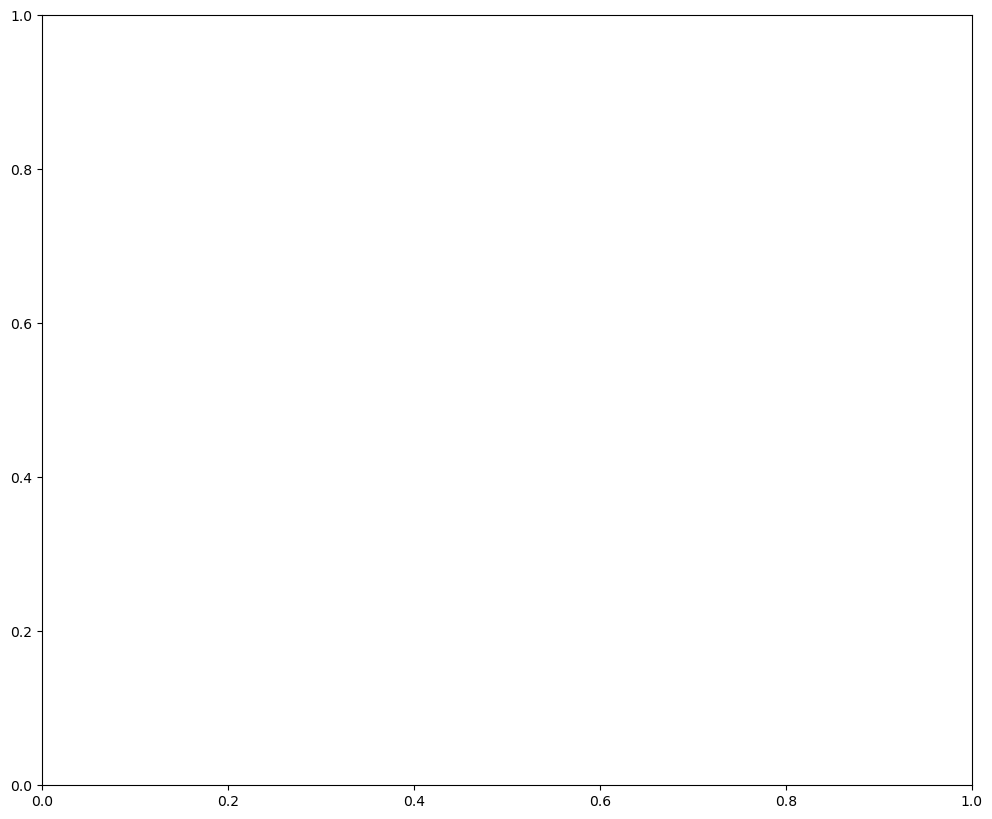

In [194]:
fig = plt.subplots(figsize = (12,10))

corr_with_target = X_train.corrwith(y_train)

print(corr_with_target)
sns.heatmap(corr_with_target, annot=True)

In [203]:
def select_features_correlation(X_train, y_train, X_test, k_features):
    # select k best features according to correlation matrix
    corr_with_target = X_train.corrwith(y_train)

    k_best = corr_with_target[0:k_features-1]
    k_best = [feature_name for feature_name, correlation_with_target in k_best.items() if feature_name != "revenues"]
    print(k_best)
    
    X_train_filtered = X_train[k_best]
    X_test_filtered = X_test[k_best]
    
    return X_train_filtered, X_test_filtered

select_features_correlation(X_train, y_train, X_test, 10)

['ratings', 'n_votes', 'production_year', 'runtime', 'release_year', 'studio', 'img_embeddings1', 'img_embeddings2', 'img_embeddings3']


(       ratings   n_votes  production_year   runtime  release_year  studio  \
 1860  0.857143 -0.152636         0.142857 -3.631579      0.833333     371   
 2459 -0.642857 -0.118577        -0.357143 -0.315789      0.583333     169   
 2508 -0.857143 -0.005466        -0.642857 -0.210526     -0.916667     470   
 1288  0.500000  6.967118        -1.214286 -0.368421     -1.666667     461   
 330   0.214286  0.332436        -0.357143 -0.105263     -0.666667     330   
 ...        ...       ...              ...       ...           ...     ...   
 783  -1.214286  0.406358         0.071429  0.105263     -0.166667     259   
 858   1.000000 -0.149777         0.357143  0.473684      0.166667     233   
 1759 -0.214286  0.424523         0.357143  3.368421      0.166667     493   
 2908 -2.142857 -0.102599         0.214286  0.842105      0.000000     102   
 3057  0.642857 -0.001682        -1.285714 -0.105263     -1.666667     274   
 
       img_embeddings1  img_embeddings2  img_embeddings3  
 18

#### Mutual information (non-linear models)

In [192]:
def select_features_MI(X_train, y_train, X_test, k_features):
    # select k best features according to MI
    k_best = SelectKBest(mutual_info_regression, k=k_features)
    k_best.fit(X_train, y_train)
    print(X_train.columns[k_best.get_support()])
    
    X_train_filtered = X_train[X_train.columns[k_best.get_support()]]
    X_test_filtered = X_test[X_train.columns[k_best.get_support()]]
    
    return X_train_filtered, X_test_filtered

select_features_MI(X_train, y_train, X_test, 10)

Index(['n_votes', 'runtime', 'release_year', 'studio', 'img_embeddings1523',
       'img_embeddings1642', 'text_embeddings122', 'text_embeddings239',
       'text_embeddings305', 'text_embeddings608'],
      dtype='object')


(       n_votes   runtime  release_year  studio  img_embeddings1523  \
 1860 -0.152636 -3.631579      0.833333     371            0.153401   
 2459 -0.118577 -0.315789      0.583333     169            0.860543   
 2508 -0.005466 -0.210526     -0.916667     470            0.093287   
 1288  6.967118 -0.368421     -1.666667     461            1.167165   
 330   0.332436 -0.105263     -0.666667     330           -0.610254   
 ...        ...       ...           ...     ...                 ...   
 783   0.406358  0.105263     -0.166667     259            1.197402   
 858  -0.149777  0.473684      0.166667     233           -0.488953   
 1759  0.424523  3.368421      0.166667     493           -0.533915   
 2908 -0.102599  0.842105      0.000000     102           -0.091429   
 3057 -0.001682 -0.105263     -1.666667     274           -0.294378   
 
       img_embeddings1642  text_embeddings122  text_embeddings239  \
 1860           -0.273817           -0.323497            0.319073   
 2459   

### Feature selection: Wrapper Method

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

forest = RandomForestRegressor(n_estimators=500, random_state=0)
forest.fit(X1_train, Y1_train)

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)

X1_selected = sfm.transform(X1_train)

feat_labels = X1_train.columns
importances = forest.feature_importances_

for i in range(X1_selected.shape[1]):
    print("%2d) %-*s %f" % (i + 1, feat_labels[indices[i]], importances[indices[i]]))

### Model selection

In [204]:
from sklearn.linear_model import LinearRegression

X_train_filtered, X_test_filtered = select_features_correlation(X_train, y_train, X_test, k_features=10)

lr = LinearRegression()

# train the model on training set
lr.fit(X_train_filtered, y_train)

# predict values with testing set
y_pred = lr.predict(X_test_filtered)

# compare predicted values with the testing target using mse
mse = mean_squared_error(y_test, y_pred)

mse

['ratings', 'n_votes', 'production_year', 'runtime', 'release_year', 'studio', 'img_embeddings1', 'img_embeddings2', 'img_embeddings3']


7.2879096654372

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()
knn.fit(X1_train, Y1_train)

In [ ]:
from torch import nn
from skorch import NeuralNetRegressor

## Prediction

We're gonna make prediction about the revenue of movies present in `X2.csv`.